In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect
from utils import *

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_planted_hamiltonian_undirected_fixed_degree
from benchmarking import new_benchmark, Solver

## Benchmarking

Creates a new benchmark

In [2]:
def generate():
  return [
    gen_planted_hamiltonian_undirected_fixed_degree(30, round(30 * deg / 2))
    for deg in np.linspace(1.0, 10.0, 10) for _ in range(50)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
	Solver("brute", "BRANCH_N_BOUND"),
	# Solver("brute", "BRUTE_FORCE_COMPLETE"),
	Solver("ilp"),
	Solver("kalp", threads=4),
	# Solver("kalp"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(15)'

Loads an existing benchmark

In [2]:
benchmark = Benchmark.load("../final_benchmarks/only_ham_3brute_ilp_kalp_deg1-10_50runs/")

Runs `benchmark`

In [ ]:
benchmark.run(retryFailures=True, timeout=3 * 60)


## Data processsing

We collect the data relating to `benchmark` into a single dataframe

In [4]:
df = benchmark.get_dataframe()
df.head()

,path,run_time,length,solver,graph_id,status,objective_value,failure,solver_name,vertices,edges,average_out_degree
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000011,29.0,0,0,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000020,29.0,0,1,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000013,29.0,0,2,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
3,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000012,29.0,0,3,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.000012,29.0,0,4,NaN,NaN,NaN,brute('FAST_BOUND'),30,58,1.933333


We find all rows for which the found length is not 29.
Since all graphs have Hamiltonian paths all found lengths should be 29.

In [5]:
df[(df["length"].notna()) & (df["length"] != 29)][["solver_name", "graph_id", "length"]]

,solver_name,graph_id,length


Creates special dataframes for plotting

In [6]:
df, df_grouped, df_grouped_failures_removed, to_plot = build_plotting_dataframes(benchmark)

A dataframe showing how many datapoints are left after removing failures

In [7]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,brute('BRANCH_N_BOUND'),10
1,brute('BRUTE_FORCE'),10
2,brute('FAST_BOUND'),10
3,ilp(),10
4,kalp(threads=4),4


In [8]:
df_grouped_failures_removed.head()

,average_out_degree,solver,solver_name,run_time_mean,run_time_median,run_time_std,failure
0,1.933333,0,brute('FAST_BOUND'),0.000013,0.000013,3.077834e-06,False
1,1.933333,1,brute('BRUTE_FORCE'),0.000002,0.000002,3.958973e-07,False
2,1.933333,2,brute('BRANCH_N_BOUND'),0.000004,0.000004,1.397374e-06,False
3,1.933333,3,ilp(),46.831174,46.170734,1.126196e+00,False
4,1.933333,4,kalp(threads=4),1.925778,1.925459,6.215199e-02,False


In [9]:
to_plot.head()


average_out_degree           run_time_mean                       \
solver_name                    brute('BRANCH_N_BOUND') brute('BRUTE_FORCE')   
0                     1.933333                0.000004             0.000002   
1                     2.000000                0.000007             0.000003   
2                     3.000000                0.000838             0.000547   
3                     4.000000                0.011184             0.034607   
4                     5.000000                0.010062             0.083281   

                                                            \
solver_name brute('FAST_BOUND')      ilp() kalp(threads=4)   
0                      0.000013  46.831174        1.925778   
1                      0.000015  22.522745        1.984495   
2                      0.005441   0.853429        0.457396   
3                      0.589332   0.783782        4.969584   
4                      1.728413   0.687463             NaN   

                       run_time_std                                           \
solver_name brute('BRANCH_N_BOUND') brute('BRUTE_FORCE') brute('FAST_BOUND')   
0                          0.000001         3.958973e-07            0.000003   
1                          0.000002         2.618693e-06            0.000005   
2                          0.000747         5.053869e-04            0.014219   
3                          0.033826         1.011500e-01            3.861899   
4                          0.033551         3.554332e-01           11.961825   

                                        
solver_name      ilp() kalp(threads=4)  
0             1.126196        0.062152  
1            14.043347        0.475445  
2             0.261148        0.992908  
3             0.211930       14.008459  
4             0.056014             NaN

## Plotting

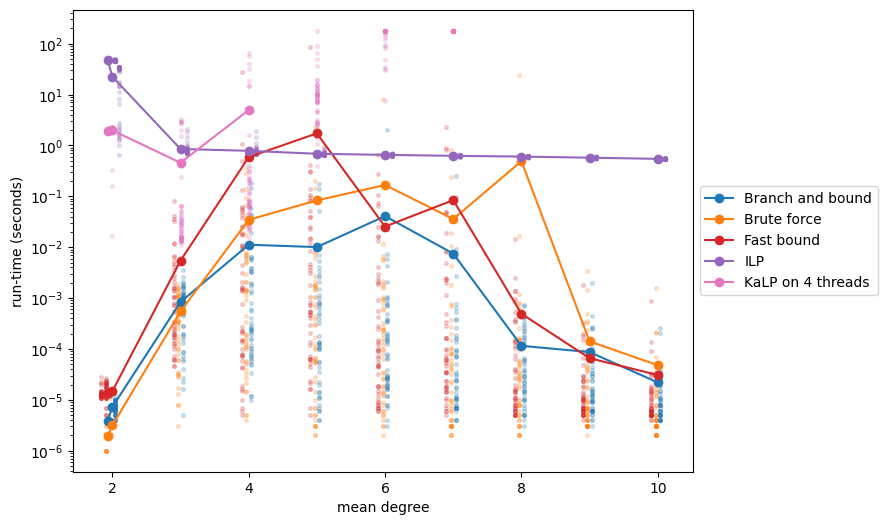

In [10]:
plt_with_scatter(benchmark, list(np.linspace(-0.1,0.1,4)) + [0])
plt.yscale('log')
plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

It is notable how low the 'spread' is for the ILP method.
Shown below is a boxplot for the ILP method.

run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

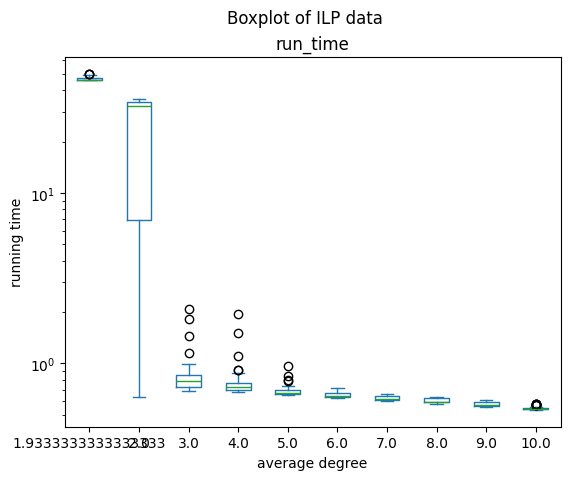

In [11]:
df[df["solver_name"] == "ilp()"][["run_time", "average_out_degree"]].plot.box(
  by="average_out_degree", 
  logy=True,
  xlabel="average degree",
  ylabel="running time",
  title="Boxplot of ILP data"
)


A plot with symmetric errorbars. 
These errorbars are a little meaningless because the distributions are very skewed, and because we prefer logarithmic axes.

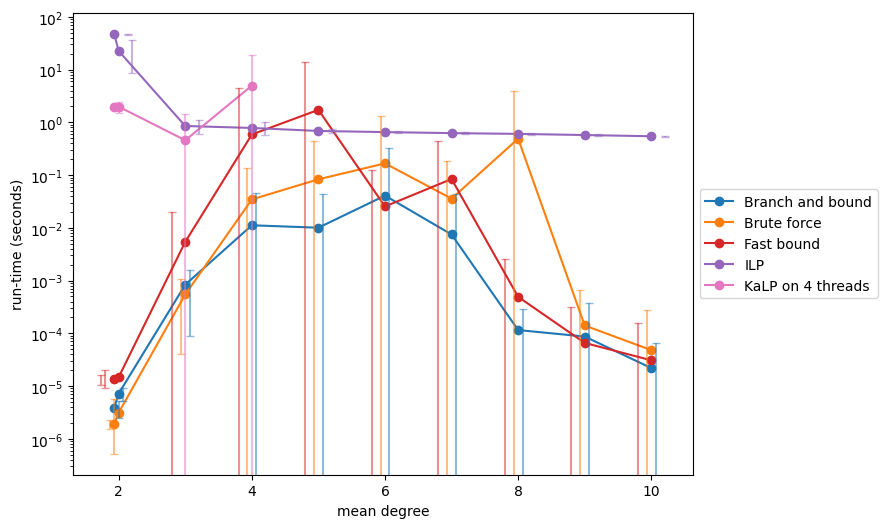

In [12]:
plot_with_symmetric_errbars(benchmark, list(np.linspace(-0.2,0.2,4)) + [0])
plt.yscale('log')
plt.gcf().set_size_inches(8, 6)